In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Load & Preparation

In [2]:

url = 'https://raw.githubusercontent.com/Redback-Operations/redback-fit-sports-performance/main/Cycling%20Analysis/data/extended_activities.csv'
# Reading the CSV file directly from the URL
df = pd.read_csv(url)
# Filtering for Running activity
df_run = df[df['Activity Type'] == 'Run']
df_run.head(3)

,Activity ID,Activity Date,Activity Name,Activity Type,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Gear,...,Maximum Power 10s,Maximum Power 30s,Maximum Power 1.0min,Maximum Power 5.0min,Maximum Power 10.0min,Maximum Power 20.0min,Maximum Power 30.0min,Maximum Power 1.0 hr,Maximum Power 1.5 hr,Maximum Power 2.0 hr
89,7057073739,"28 Apr 2022, 21:49:44",Morning Run,Run,4127,12.77,178.0,78.0,False,NaN,...,296.8,271.9,259.4,247.5,242.9,241.5,239.5,235.6,0.0,0.0
90,7067754767,"1 May 2022, 00:11:03",Morning Run,Run,7723,24.63,173.0,185.0,False,NaN,...,376.5,343.7,326.4,316.3,315.0,297.3,291.1,280.1,275.8,272.1
91,7073448977,"1 May 2022, 23:04:26",Morning Run,Run,4202,12.51,182.0,255.0,False,NaN,...,342.0,300.0,282.7,267.1,262.4,261.1,258.3,253.2,0.0,0.0


In [3]:
# Listing the columns of the Running dataset
df_run.columns

Index(['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type',
       'Elapsed Time', 'Distance', 'Max Heart Rate', 'Relative Effort',
       'Commute', 'Activity Gear', 'Filename', 'Athlete Weight', 'Bike Weight',
       'Moving Time', 'Max Speed', 'Average Speed', 'Elevation Gain',
       'Elevation Loss', 'Elevation Low', 'Elevation High', 'Max Grade',
       'Average Grade', 'Max Cadence', 'Average Cadence', 'Average Heart Rate',
       'Average Watts', 'Calories', 'Average Temperature', 'Total Work',
       'Perceived Exertion', 'Weighted Average Power', 'Power Count',
       'Prefer Perceived Exertion', 'Perceived Relative Effort',
       'Grade Adjusted Distance', 'Average Elapsed Speed', 'Dirt Distance',
       'Total Steps', 'Maximum Power 5s', 'Maximum Power 10s',
       'Maximum Power 30s', 'Maximum Power 1.0min', 'Maximum Power 5.0min',
       'Maximum Power 10.0min', 'Maximum Power 20.0min',
       'Maximum Power 30.0min', 'Maximum Power 1.0 hr', 'Maximum Power 1

## Predictive modelling using Gradient Boosting Regression

## Prediction - Elapsed time

In [4]:
# Importing libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

In [5]:
# Defining function to plot prediction - Elapsed Time
def plot_results(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Elapsed Time')
    plt.ylabel('Predicted Elapsed Time')
    plt.title('Actual vs Predicted Elapsed Time: {}'.format(model_name))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

In [6]:
# Subsetting the running dataset for predicting Elapsed Time, using only Distance, Power Count (input variables) and Elapsed Time (target variable)
# ET = Elapsed Time
data_ET = df_run[['Distance', 'Power Count', 'Elapsed Time']]
print(data_ET.shape)
print(data_ET.columns)

(164, 3)
Index(['Distance', 'Power Count', 'Elapsed Time'], dtype='object')


In [7]:
# Removing outliers using IQR approach
# Setting up IQR range
Q1_ET = data_ET.quantile(0.25)
Q3_ET = data_ET.quantile(0.75)
IQR_ET = Q3_ET - Q1_ET

# Creating cleaned dataset by removing identified outliers
data_ET_cl = data_ET[~((data_ET < (Q1_ET - 1.5 * IQR_ET)) |(data_ET > (Q3_ET + 1.5 * IQR_ET))).any(axis=1)]

# Checking dataset before and after outlier removal
print("original dataset shape: ", data_ET.shape)
print('number of outliers:', len(data_ET)-len(data_ET_cl))
print("new dataset shape: ", data_ET_cl.shape)

original dataset shape:  (164, 3)
number of outliers: 8
new dataset shape:  (156, 3)


In [8]:
# Setting up input features and target variable
X_ET = data_ET_cl[['Distance', 'Power Count']]  # Features
y_ET = data_ET_cl['Elapsed Time']   # Target variable

In [9]:
# Splitting the data into training and testing sets
X_train_ET, X_test_ET, y_train_ET, y_test_ET = train_test_split(X_ET, y_ET, test_size=0.2, random_state=201)

# Scaling the training data
scaler = StandardScaler()
X_train_ET = scaler.fit_transform(X_train_ET) 
X_test_ET = scaler.transform(X_test_ET)  

In [12]:
# Hyperparameter optimization using randomised search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

In [13]:
# Setting up range of hyperparameters for optimisation
params_ET = {
    'n_estimators': np.arange(20, 240, 20),
    'learning_rate': np.linspace(0.01, 0.5, 20),
    'max_depth': np.arange(3, 9),
}
 
model_ET_rnd = GradientBoostingRegressor()
 
# Creating RandomizedSearchCV
cv_ET = RepeatedKFold(n_splits=10, n_repeats=3, random_state=19)
random_search_ET = RandomizedSearchCV(estimator=model_ET_rnd, param_distributions=params_ET, cv=cv_ET, scoring='r2', random_state=19, n_jobs=-1)
 
# Fitting the model to the training data using RandomizedSearchCV
random_search_ET.fit(X_train_ET, y_train_ET)
 
# Getting the best parameters and best model
best_params_ET = random_search_ET.best_params_
best_model_ET = random_search_ET.best_estimator_
 
# Making predictions on the test set and identifying the best model
y_pred_best_ET = best_model_ET.predict(X_test_ET)
 
# Evaluating the best model
mse_ET_rnd = mean_squared_error(y_test_ET, y_pred_best_ET)
rmse_ET_rnd = np.sqrt(mse_ET_rnd)
r2_ET_rnd = r2_score(y_test_ET, y_pred_best_ET)

# Printing results
print("Best Parameters:", best_params_ET)
print(f'Mean Squared Error: {mse_ET_rnd}')
print(f'Root Mean Squared Error: {rmse_ET_rnd}')
print(f'R² Score: {r2_ET_rnd}')


Best Parameters: {'n_estimators': 140, 'max_depth': 5, 'learning_rate': 0.24210526315789474}
Mean Squared Error: 11520.880397844454
Root Mean Squared Error: 107.33536415294101
R² Score: 0.9965293428692843


In [14]:
# Setting up range of hyperparameters for optimisation
params_ET = {
    'n_estimators': np.arange(20, 240, 20),
    'learning_rate': np.linspace(0.01, 0.5, 20),
    'max_depth': np.arange(3, 9),
}
 
model_ET_rnd = GradientBoostingRegressor()
 
# Creating RandomizedSearchCV
cv_ET = RepeatedKFold(n_splits=10, n_repeats=3, random_state=19)
random_search_ET = RandomizedSearchCV(estimator=model_ET_rnd, param_distributions=params_ET, cv=cv_ET, scoring='r2', random_state=19, n_jobs=-1)
 
# Fitting the model to the training data using RandomizedSearchCV
random_search_ET.fit(X_train_ET, y_train_ET)
 
# Getting the best parameters and best model
best_params_ET = random_search_ET.best_params_
best_model_ET = random_search_ET.best_estimator_
 
# Making predictions on the test set and identifying the best model
y_pred_best_ET = best_model_ET.predict(X_test_ET)
 
# Evaluating the best model
mse_ET_rnd = mean_squared_error(y_test_ET, y_pred_best_ET)
rmse_ET_rnd = np.sqrt(mse_ET_rnd)
r2_ET_rnd = r2_score(y_test_ET, y_pred_best_ET)

# Printing results
print("Best Parameters:", best_params_ET)
print(f'Mean Squared Error: {mse_ET_rnd}')
print(f'Root Mean Squared Error: {rmse_ET_rnd}')
print(f'R² Score: {r2_ET_rnd}')


Best Parameters: {'n_estimators': 60, 'max_depth': 3, 'learning_rate': 0.1131578947368421}
Mean Squared Error: 9479.86987583048
Root Mean Squared Error: 97.36462332813947
R² Score: 0.99714419585599


In [ ]:
# Importing libraries for randomised search optimisation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

In [15]:
# Hyperparameter optimization using randomised search
# Parameter setup for random search
params_ET = {
    'n_estimators': np.arange(20, 240, 20),
    'learning_rate': np.linspace(0.01, 0.5, 20),
    'max_depth': np.arange(3, 9),
}
 
model_ET_rnd = GradientBoostingRegressor()
 
# Creating RandomizedSearchCV
cv_ET = RepeatedKFold(n_splits=10, n_repeats=3, random_state=19)
random_search_ET = RandomizedSearchCV(estimator=model_ET_rnd, param_distributions=params_ET, cv=cv_ET, scoring='r2', random_state=19, n_jobs=-1)
 
# Fitting the model to the training data using RandomizedSearchCV
random_search_ET.fit(X_train_ET, y_train_ET)
 
# Getting the best parameters and best model
best_params_ET = random_search_ET.best_params_
best_model_ET = random_search_ET.best_estimator_
 
# Making predictions on the test set using the best model
y_pred_best_ET = best_model_ET.predict(X_test_ET)
 
# Evaluating the selected best model
mse_ET_rnd = mean_squared_error(y_test_ET, y_pred_best_ET)
rmse_ET_rnd = np.sqrt(mse_ET_rnd)
r2_ET_rnd = r2_score(y_test_ET, y_pred_best_ET)

# Printing results
print("Best Parameters:", best_params_ET)
print(f'Mean Squared Error: {mse_ET_rnd}')
print(f'Root Mean Squared Error: {rmse_ET_rnd}')
print(f'R² Score: {r2_ET_rnd}')


Best Parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.29368421052631577}
Mean Squared Error: 9674.482817111846
Root Mean Squared Error: 98.3589488410274
R² Score: 0.9970855688440722


In [16]:
# Creating a Gradient Boosting Regression model based on optimised hyperparameters
model_ET = GradientBoostingRegressor(loss='squared_error', n_estimators=60, max_depth=3, learning_rate= 0.11)
model_ET.fit(X_train_ET, y_train_ET)

GradientBoostingRegressor(learning_rate=0.11, n_estimators=60)

Mean Squared Error: 7837.098703325133
Root Mean Squared Error: 88.52738956574476
R² Score: 0.9976390795182712


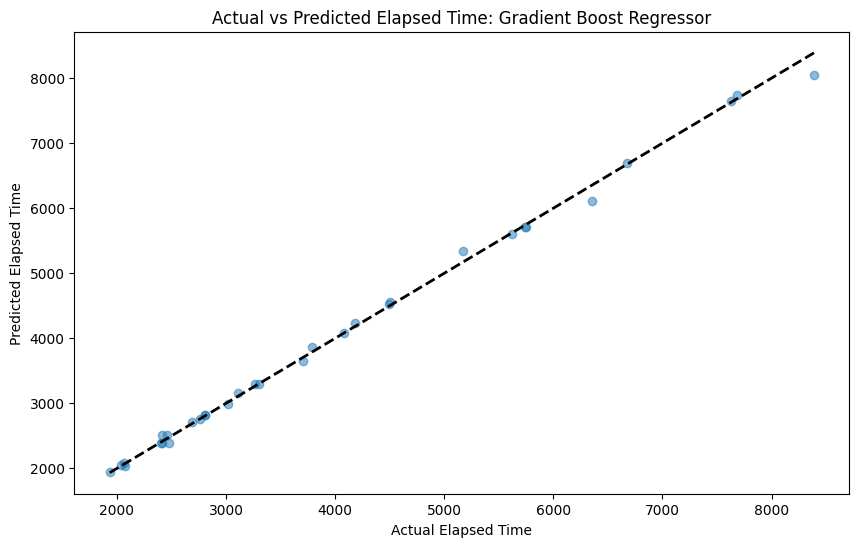

In [17]:

# Predicting on the testing dataset
y_pred_ET= model_ET.predict(X_test_ET)

# Evaluating the optimised model
mse_ET = mean_squared_error(y_test_ET, y_pred_ET)
rmse_ET = np.sqrt(mse_ET)
r2_ET = r2_score(y_test_ET, y_pred_ET)

print(f'Mean Squared Error: {mse_ET}')
print(f'Root Mean Squared Error: {rmse_ET}')
print(f'R² Score: {r2_ET}')
plot_results(y_test_ET, y_pred_ET, 'Gradient Boost Regressor')

## Prediction - Calories

In [18]:
# Defining function to plot prediction - Calories
def plot_results2(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Calories')
    plt.ylabel('Predicted Calories')
    plt.title('Actual vs Predicted Calories: {}'.format(model_name))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
    plt.show()

In [19]:
# Subsetting the running dataset to predict Calories, using only Distance, Moving Time, Power Count (input variables) and Calories (target variable)
# CAL = Calories
data_CAL = df_run[['Distance', 'Moving Time','Power Count', 'Calories']]
print(data_CAL.shape)
print(data_CAL.columns)

(164, 4)
Index(['Distance', 'Moving Time', 'Power Count', 'Calories'], dtype='object')


In [20]:
# Removing outliers using IQR approach
# Setting up IQR range
Q1_CAL = data_CAL.quantile(0.25)
Q3_CAL = data_CAL.quantile(0.75)
IQR_CAL = Q3_CAL - Q1_CAL

# Creating cleaned dataset by removing identified outliers
data_CAL_cl = data_CAL[~((data_CAL < (Q1_CAL - 1.5 * IQR_CAL)) |(data_CAL > (Q3_CAL + 1.5 * IQR_CAL))).any(axis=1)]

# Checking dataset before and after outlier removal
print("original dataset shape: ", data_CAL.shape)
print('number of outliers:', len(data_CAL)-len(data_CAL_cl))
print("new dataset shape: ", data_CAL_cl.shape)

original dataset shape:  (164, 4)
number of outliers: 8
new dataset shape:  (156, 4)


In [21]:
# Setting up input features and target variable (CAL = Calories)
X_CAL = data_CAL_cl[['Distance', 'Moving Time', 'Power Count']]  # Features
y_CAL = data_CAL_cl['Calories']   # Target variable

# Splitting the data into training and testing sets
X_train_CAL, X_test_CAL, y_train_CAL, y_test_CAL = train_test_split(X_CAL, y_CAL, test_size=0.2, random_state=21)

# Scaling the training data
scaler = StandardScaler()
X_train_CAL = scaler.fit_transform(X_train_CAL) 
X_test_CAL = scaler.transform(X_test_CAL)  

In [22]:
# Setting up range of hyperparamters for randomised search
params_CAL = {
    'n_estimators': np.arange(20, 240, 20),
    'learning_rate': np.linspace(0.01, 0.5, 30),
    'max_depth': np.arange(1, 5),
}
 
model_CAL_rnd = GradientBoostingRegressor(loss='squared_error')
 
# Creating RandomizedSearchCV
cv_CAL = RepeatedKFold(n_splits=10, n_repeats=3, random_state=21)
random_search_CAL = RandomizedSearchCV(estimator=model_CAL_rnd, param_distributions=params_CAL, cv=cv_CAL, scoring='r2', random_state=21, n_jobs=-1)
 
# Fitting the model to the training data using RandomizedSearchCV
random_search_CAL.fit(X_train_CAL, y_train_CAL)
 
# Getting the best parameters and best model
best_params_CAL = random_search_CAL.best_params_
best_model_CAL = random_search_CAL.best_estimator_
 
# Making predictions and identifying the best model
y_pred_best_CAL = best_model_CAL.predict(X_test_CAL)
 
# Evaluate the best model
mse_CAL_rnd = mean_squared_error(y_test_CAL, y_pred_best_CAL)
rmse_CAL_rnd = np.sqrt(mse_CAL_rnd)
r2_CAL_rnd = r2_score(y_test_CAL, y_pred_best_CAL)

# Printing results
print("Best Parameters:", best_params_CAL)
print(f'Mean Squared Error: {mse_CAL_rnd}')
print(f'Root Mean Squared Error: {rmse_CAL_rnd}')
print(f'R² Score: {r2_CAL_rnd}')

Best Parameters: {'n_estimators': 120, 'max_depth': 1, 'learning_rate': 0.29724137931034483}
Mean Squared Error: 7328.356867246697
Root Mean Squared Error: 85.60582262467138
R² Score: 0.9543461269601193


Mean Squared Error: 7281.236095661806
Root Mean Squared Error: 85.33015935565693
R² Score: 0.9546396778559678


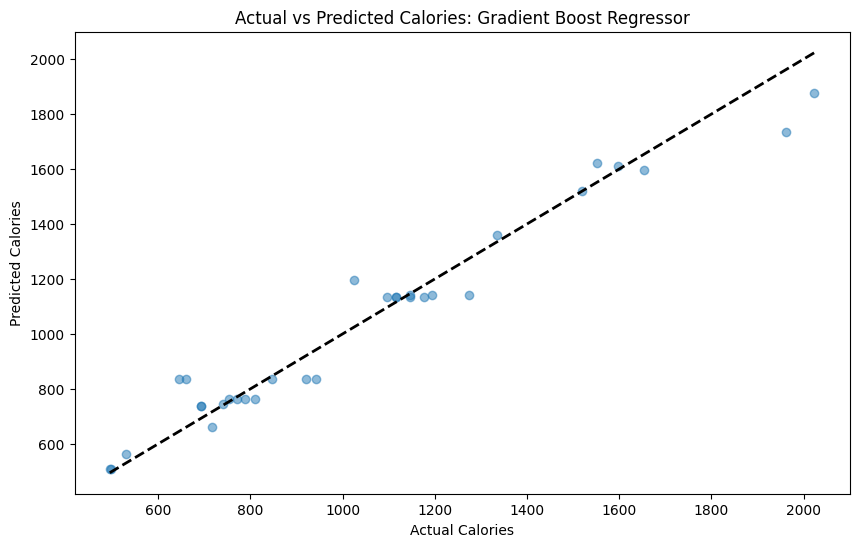

In [23]:
# Creating a Gradient Boosting Regression model using the optimised hyperparameters
model_CAL = GradientBoostingRegressor(loss='squared_error', n_estimators = 120, max_depth = 1, learning_rate= 0.297)
model_CAL.fit(X_train_CAL, y_train_CAL)

# Predicting on the testing set
y_pred_CAL= model_CAL.predict(X_test_CAL)

# Evaluating the model
mse_CAL = mean_squared_error(y_test_CAL, y_pred_CAL)
rmse_CAL = np.sqrt(mse_CAL)
r2_CAL = r2_score(y_test_CAL, y_pred_CAL)

print(f'Mean Squared Error: {mse_CAL}')
print(f'Root Mean Squared Error: {rmse_CAL}')
print(f'R² Score: {r2_CAL}')
plot_results2(y_test_CAL, y_pred_CAL, 'Gradient Boost Regressor')
